# Training a hand made Neural Network

Importing the required libraries.

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

# Initializing parameters before Training

Here I have used He initialization of parameters.   
This initialization prevents the value of 'z' or 'a' from overshooting or shrinking and thus does not retard the training process.

In [48]:
def initialize_parameters_he(layer_dims, load_pretrained):
    parameters = {}

    # number of layers in the network
    num_layers = len(layer_dims)

    if(load_pretrained):  # If loading pretrained parameters
            for l in range(1, num_layers):
                parameters['W' + str(l)] = np.array(np.load("parametersW" + str(l) + ".npy"))
                parameters['b' + str(l)] = np.array(np.load("parametersb" + str(l) + ".npy"))
                
                assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
                assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
            
            return parameters
    
    # He initialization works well for networks with ReLU activations.
    # As the length of layer dims goes from 0 to L-1 , we go from 1 to L-1 as 0th layer is i/p layer
    # The initialization is done this way to avoid exploding and diminishing of output of each layer
    for l in range(1, num_layers):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

Initializing the momentum parameters for each layer.

In [49]:
def initialize_velocity_momentum(parameters):
    v = {}
    num_layers = len(parameters) // 2  # Number of layers

    for i in range(1, num_layers + 1):
        v["dw" + str(i)] = np.zeros((parameters["W" + str(i)].shape[0], parameters["W" + str(i)].shape[1]))
        v["db" + str(i)] = np.zeros((parameters["b" + str(i)].shape[0], parameters["b" + str(i)].shape[1]))
        
        assert(v["dw" + str(i)].shape == parameters["W" + str(i)].shape)
        assert(v["db" + str(i)].shape == parameters["b" + str(i)].shape)

    return v


# Forward Propagation functions

linear_forward calculates the value of z using the previous layer's output.   
The function returns the cache of previous layer's output with current layer's parameters.

In [50]:
def linear_forward(a, w, b):
    z = np.dot(w,a) + b

    assert(z.shape == (w.shape[0], a.shape[1])),"Shape of calculated Z is incorrect in linear_forward function"
    cache = (a, w, b)

    return z, cache

The function relu calculates the output value of a layer using Relu activation.   
Similarly the function sigmoid is used to calculate the output of the final layer when performing binary classification.

In [51]:
def relu(z):
    a = z * (z > 0)
    activation_cache = {"Z": z}

    assert(a.shape == z.shape),"a's shape is not same as z in relu function"
    return a, activation_cache


def sigmoid(z):
    a = 1/(1 + np.exp(-1*z))
    activation_cache = {"Z": z}

    assert(a.shape == z.shape),"a's shape is not same as z in sigmoid function"
    return a, activation_cache

The below function uses the activation according to the specified input.   
It uses both of the above mentioned functions.   
It returns a cache of the current layer's 'z' and previous layer's 'a' and current layer's  'w' and 'b'.

In [52]:
def linear_activation_forward(a_prev, w, b, activation):
    # Linear cache contains previous layer's activation output, current layer's W and b
    # Activation cache contains current layer's Z

    if activation == "relu":
        z, linear_cache = linear_forward(a_prev, w, b)
        a, activation_cache = relu(z)

    elif activation == "sigmoid":
        z, linear_cache = linear_forward(a_prev, w, b)
        a, activation_cache = sigmoid(z)

    assert (a.shape == (w.shape[0], a_prev.shape[1])),"Calculated shape of A is incorrect"

    # linear_cache contains previous input, current w,b
    # activation_cache contains current z
    cache = (linear_cache, activation_cache)

    return a, cache


L_model_forward combines all of the above functions.   
It calculates output values for each layer using Relu activation except the last one where it uses sigmoid.    
The parameters at each layer along with the layer's output are stored to be used while backpropagation.

In [53]:
def L_model_forward(x, parameters):
    # caches contain every layer's tuple of both linear cache and activation cache 
    # which are used during backward prop
    # Linear cache consists of previous activation
    cache_main = []
    a = x
    num_layers = len(parameters) // 2

    # Implement [LINEAR -> RELU]*(L-1).
    for l in range(1, num_layers):
        a_prev = a
        a, cache_temp = linear_activation_forward(a_prev, parameters["W" + str(l)], 
                                                  parameters["b" + str(l)], "relu")
        cache_main.append(cache_temp)

    # Implement LINEAR -> Sigmoid since the current problem is a binary classification one.
    # For last layer
    al, cache_temp = linear_activation_forward(a, parameters["W" + str(num_layers)],
                                               parameters["b" + str(num_layers)], "sigmoid")
    cache_main.append(cache_temp)

    assert (al.shape == (1, x.shape[1]))

    # Finally we return last layer activation funcn and caches containing information of all layers
    return al, cache_main


# Cost Computation

Computing cost using L2 regularization.   
Regularization helps prevent overfitting. Too large a value of lambda(regularization parameter) causes high bias problems and too low a value causes high variance.   
However, it is always better to overfit the model on the training data first and then improve it's performance on the dev/test data by varying the value of lambda.

In [54]:
def compute_cost_with_L2(al, y, parameters, lambd):
    m = y.shape[1]  # Number of examples
    parameters_sum = []
    num_layers = len(parameters) // 2

    # L2 regularization cost
    for i in range(1, num_layers + 1):
        parameters_sum.append( np.sum( np.square(parameters["W" + str(i)]) ) )
    l2_cost = (lambd/(2 * m))*( np.sum(parameters_sum) )

    # Below code computes cost for sigmoid function
    cross_entropy_cost = (-1/m)*( np.sum( y*np.log(al) ) + np.sum( (1 - y)*np.log(1 - al) ) )

    return cross_entropy_cost + l2_cost


def compute_cost(al, y, parameters, lambd):
    # Compute loss from al and y, none other cache information is needed
    cost = compute_cost_with_L2(al, y, parameters, lambd)

    # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    cost = np.squeeze(cost)
    assert(cost.shape == ()),"cost's shape is incorrect"

    return cost

# Backward Propagation Functions

The below functions calculates the derivative of the Relu and the Sigmoid activation functions.   
The below functions assumes da to be derivative of loss function w.r.t the activation a.    
By chain rule, dz = (da)*(g'(z)) where g(z) is the activation function.   

In [55]:
def relu_backward(da, activation_cache):
    # Since dz = da * g'(z)
    z = activation_cache["Z"]
    
    dz = np.multiply(da, np.int64(z > 0))
    
    assert (z.shape == dz.shape)
    return dz


In [56]:
def sigmoid_backward(da, activation_cache):
    # Since dz = da * g'(z)
    z = activation_cache["Z"]
    a = 1/(1 + np.exp(-1 * z))
    
    dz = np.multiply(da, a*(1 - a))
    
    assert (z.shape == dz.shape)
    return dz 


dz calculated from previous functions are used to calculate the gradients of other parameters that are stored in the cache.

In [57]:
def linear_backward(dz, cache, lambd):
    # We need dz of any layer before calculating other gradients of that layer
    # dz is caculated from dA , which is then used to calculate dA_prev

    a_prev, w, b = cache
    m = a_prev.shape[1]

    dw = (1/m)*(np.dot(dz,a_prev.T)) + (lambd/m)*w
    db = (1/m)*(np.sum(dz, axis = 1, keepdims = True))
    da_prev = np.dot(w.T,dz)

    assert (da_prev.shape == a_prev.shape)
    assert (dw.shape == w.shape)
    assert (db.shape == b.shape)

    return da_prev, dw, db

The below function combines both the upper functions.   
Using the current layer's da and dz, we get the previous layer's da and current layer's     
dw and db.

In [58]:
def linear_activation_backward(da, cache, activation, lambd):
    # cache is of a particular layer, this function is run for every layer to calculate dA_prev for preceding layer
    linear_cache, activation_cache = cache

    # To calculate dz we need da
    # dz of current layer is necessary to calculate every other gradient
    if activation == "relu":
        dz = relu_backward(da, activation_cache)
        da_prev, dw, db = linear_backward(dz, linear_cache, lambd)

    if activation == "sigmoid":
        dz = sigmoid_backward(da, activation_cache)
        da_prev, dw, db = linear_backward(dz, linear_cache, lambd)
        
    # da_prev is gradient of previous layer's output that is a_prev
    return da_prev, dw, db

In the below function we create a dictionary 'grads' to store the gradients of every layer.

In [59]:
def L_model_backward(al, y, caches, lambd):
    grads = {}
    num_layers = len(caches)

    m = al.shape[1]
    y = y.reshape(al.shape)

    # Below dal is input to the last layer
    # derivative of cost with respect to al is dal
    dal = - (np.divide(y, al) - np.divide(1 - y, 1 - al))

    # num_layers - 1 indexing since list goes from 0 to num_layers - 1 for length of num_layers
    current_cache = caches[num_layers - 1]
    linear_cache, activation_cache = current_cache

    # Every layer has it's own dw, db but da of previous layer i.e da_prev
    grads["dA" + str(num_layers)], grads["dW" + str(num_layers)], grads["db" + str(num_layers)] =\
                                                    linear_activation_backward(dal, current_cache,
                                                                               "sigmoid", lambd)

    # Following loop starts from l - 2 layer as last layer is l - 1 for which da_prev calculated i.e da
    for l in reversed(range(num_layers - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]

        da_prev_temp, dw_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache,
                                                                    "relu", lambd)

        # grads is a dictionary from 1 to num_layers
        grads["dA" + str(l + 1)] = da_prev_temp
        grads["dW" + str(l + 1)] = dw_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# Update Parameters

In [60]:
def update_parameters_with_momentum(parameters, grads, learning_rate, v, beta):
    """
    Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples,
    the direction of the update has some variance, and so the path taken by mini-batch gradient descent will
    "oscillate" toward convergence. Using momentum can reduce these oscillations.

    Momentum takes into account the past gradients to smooth out the update. We will store the 'direction'
    of the previous gradients in the variable v . Formally, this will be the exponentially weighted average
    of the gradient on previous steps. You can also think of v as the "velocity" of a ball rolling downhill,
    building up speed (and momentum) according to the direction of the gradient/slope of the hill.
    """
    num_layers = len(parameters) // 2

    # Update rule for each parameter.
    for l in range(1, num_layers + 1):
        v["dw" + str(l)] = beta*v["dw" + str(l)] + (1 - beta)*grads["dW" + str(l)]
        v["db" + str(l)] = beta*v["db" + str(l)] + (1 - beta)*grads["db" + str(l)]
        parameters["W" + str(l)] -= (learning_rate * v["dw" + str(l)])
        parameters["b" + str(l)] -= (learning_rate * v["db" + str(l)])

    return parameters, v


Randomly selecting the batches from training data.   
The batches selected after each epoch are random ,but the batch size is constant.

In [61]:
def random_mini_batches(x, y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)

    m = x.shape[1]  # Training examples length
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_x = x[ :, permutation]
    shuffled_y = y[ :, permutation].reshape((1, m))

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_x = shuffled_x[ :, k*(mini_batch_size) : (k + 1)*(mini_batch_size)]
        mini_batch_y = shuffled_y[ :, k*(mini_batch_size) : (k + 1)*(mini_batch_size)]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_x = shuffled_x[:,num_complete_minibatches*mini_batch_size : ]
        mini_batch_y = shuffled_y[:,num_complete_minibatches*mini_batch_size : ]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    return mini_batches


In [62]:
def predict_train_accuracy(train_x, train_y, parameters):
    al, caches = L_model_forward(train_x, parameters)
    
    assert (al.shape == train_y.shape), "shapes are not equal of al and y_train in predict"
    count = 0
    for i in range(al.shape[1]):
        # Below two lines converts the sigmoid's output to zero or one
        if al[0, i] >= 0.5: al[0, i] = 1
        else: al[0, i] = 0

        # Increasing the count only if both outputs are same
        if al[0, i] == train_y[0, i]: count += 1

    accuracy = (count / al.shape[1]) * 100
    print("Train accuracy is %i" % (accuracy))

# Training the Neural Network

The training is performed for the specified number of epochs.    
In one epoch we go through the entire training data once.    
For the cases when the size of training data is huge, we perform batch training(breaking the data into batches).        
The training procedure is as follows :-     
1) Iterate over a minibatch at a time.     
2) Forward Propagation.      
3) Cost Computation.    
4) Backward Propagation    
5) Update Parameters

In [75]:
def L_layer_model(x, y, layer_dims, learning_rate, epochs, print_cost, batch_size, load_pretrained):
    costs = []
    seed = 10
    lambd = 0.3  # regularization parameter

    # First initialize parameters for each layer
    # Initialize parameters for momentum for each layer
    parameters = initialize_parameters_he(layer_dims, load_pretrained)
    v = initialize_velocity_momentum(parameters)

    # Here we are implementing batch gradient descent
    for i in range(0, epochs):
        seed += 1
        minibatches = random_mini_batches(x, y, batch_size, seed)
        for minibatch in minibatches:
            minibatch_x, minibatch_y = minibatch

            # A single forward pass
            al, caches = L_model_forward(minibatch_x, parameters)

            # Cost computing
            cost = compute_cost(al, minibatch_y, parameters, lambd)

            # Backward Pass
            grads = L_model_backward(al, minibatch_y, caches, lambd)

            # Update parameters
            parameters, v = update_parameters_with_momentum(parameters, grads, learning_rate, v, 0.9)

        # The below code saves the parameters after each epoch
        for k in range(1, len(layer_dims)):
            np.save("parametersW%i.npy" % (k), parameters["W" + str(k)])
            np.save("parametersb%i.npy" % (k), parameters["b" + str(k)])

        if print_cost and i % 10 is 0:
            print("Cost after epoch %i: %f" % (i, cost))
            predict_train_accuracy(x, y, parameters)
        if print_cost:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per twos)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters


# Loading the Training Data

The data below consists of images of cats and dogs taken from a Kaggle kernel :  https://www.kaggle.com/c/dogs-vs-cats.         
I have taken only 500 images each of cats and dogs for simplicity and to prove the working of the written deep neural network.    

In [76]:
def load_data(path):
    image_names = os.listdir(path)  # Put all the training images at this path
    
    train_images = []
    train_labels = []
    for img_ in image_names:
        img1 = Image.open(path + img_)
        img2 = np.array(img1.resize((64, 64), Image.ANTIALIAS))  # Resizing each image to (64, 64, 3)
        train_images.append(img2)
        if "cat" in img_: train_labels.append(0)  # each training image has 'cat' or 'dog' in it's name
        else: train_labels.append(1)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    train_labels = np.expand_dims(train_labels, axis = -1)
    
    return train_images, train_labels

In [77]:
def shuffle(a, b):
    permutation = list(np.random.permutation(a.shape[1]))
    a = a[ :, permutation]
    b = b[ :, permutation].reshape((1,a.shape[1]))
    return a, b


In [78]:
def preprocess(train_x_orig, train_y_orig):
    # Reshaping the images to vectors of following form (num_features, num_training_examples)
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
    train_y = train_y_orig.reshape(train_y_orig.shape[0], -1).T

    # Normalizing values
    train_x = train_x_flatten/255

    train_x, train_y = shuffle(train_x, train_y)  # shuffling the training images and labels
    
    return train_x, train_y

# Let's start Training!

In [79]:
# Load data is a function that loads data
train_x_orig, train_y_orig = load_data("./Data/Train/")

train_x, train_y = preprocess(train_x_orig, train_y_orig)

print(np.shape(train_x))
print(np.shape(train_y))


(12288, 999)
(1, 999)


Cost after epoch 0: 0.737153
Train accuracy is 48
Cost after epoch 10: 0.731920
Train accuracy is 54
Cost after epoch 20: 0.725031
Train accuracy is 59
Cost after epoch 30: 0.719836
Train accuracy is 61
Cost after epoch 40: 0.711972
Train accuracy is 63
Cost after epoch 50: 0.701179
Train accuracy is 65
Cost after epoch 60: 0.695176
Train accuracy is 66
Cost after epoch 70: 0.678445
Train accuracy is 66
Cost after epoch 80: 0.685507
Train accuracy is 67
Cost after epoch 90: 0.669178
Train accuracy is 69


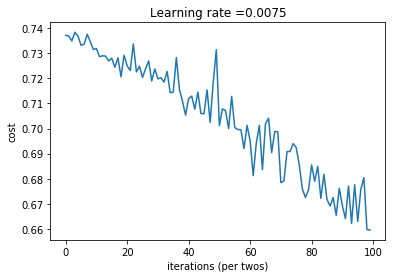

In [80]:
layer_dims = [12288, 20, 7, 5, 1]

parameters = L_layer_model(train_x, train_y, layer_dims, 0.0075, 100, True, 256, False)

# Testing on Random images

It is a Cat


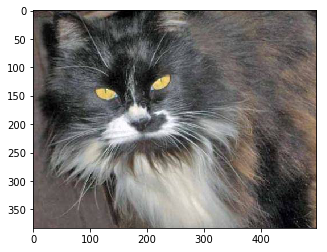

In [82]:
path = "./Data/Test/"
test_image_names = os.listdir(path)

img1 = Image.open(path + test_image_names[1])
img2 = np.array(img1.resize((64, 64), Image.ANTIALIAS))  # Resizing the image to (64, 64, 3)
img2 = np.expand_dims(img2, axis = 0)
img2 = img2.reshape(img2.shape[0], -1).T
img2 = img2/255

al, caches = L_model_forward(img2, parameters)
if al >= 0.5: print("It is a Dog")
else: print("It is a Cat")

plt.imshow(np.array(img1))
plt.show()